In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, f1_score, fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.compose import make_column_transformer

from xgboost import XGBClassifier



pd.set_option('display.float_format', lambda x: '%.2f' % x)
RSEED = 42

In [2]:
df = pd.read_csv('data/cleaned/train.csv')
df_test = pd.read_csv('data/cleaned/test.csv')
df.head()


,district,client_id,client_catg,region,target,reading_remarque,counter_coeff,consommation_per_month,months_number,elec,gaz
0,63,train_Client_33962,11,101,0.00,6.00,1.00,113.27,4.00,1,1
1,62,train_Client_32174,11,301,0.00,6.00,1.00,8.11,3.40,1,1
2,69,train_Client_18868,11,107,0.00,6.00,1.00,70.77,4.00,1,1
3,62,train_Client_39728,11,310,0.00,6.00,1.00,144.65,4.11,1,0
4,60,train_Client_34246,11,101,0.00,6.00,1.00,120.93,3.96,1,1


## Split Target, Drop ID

In [3]:
y_train = df['target']
X_train = df.drop(['target', 'client_id'], axis=1)

In [4]:
# Helper: Check specific columns:
X_train.iloc[:,5].sort_values(ascending=False).nunique()

105312

In [12]:
# Helper (compare X_train and X_test below):
X_train.head(2)

,district,client_catg,region,reading_remarque,counter_coeff,consommation_per_month,months_number,elec,gaz
0,63,11,101,6.00,1.00,113.27,4.00,1,1
1,62,11,301,6.00,1.00,8.11,3.40,1,1


In [13]:
#Split target from test data
y_test = df_test['target']
X_test = df_test.drop(['target'], axis=1)

In [14]:
# Helper (compare X_train and X_test):
X_test.head(2)

,district,client_catg,region,reading_remarque,counter_coeff,consommation_per_month,months_number,elec,gaz
0,69,11,104,8.00,1.00,52.00,4.00,1,0
1,62,11,301,6.00,1.00,117.75,4.00,1,0


## Scaling the data

<Axes: xlabel='consommation_per_month', ylabel='Count'>

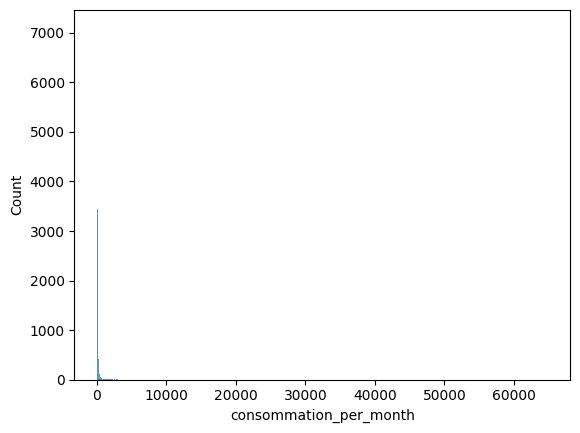

In [15]:
sns.histplot(X_train['consommation_per_month'])

<Axes: xlabel='months_number', ylabel='Count'>

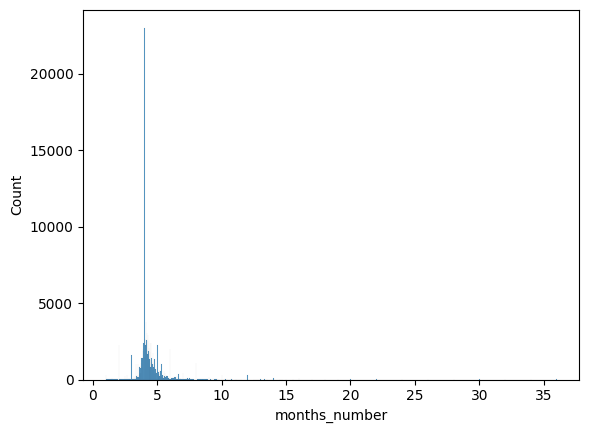

In [16]:
sns.histplot(X_train['months_number'])

<span style='color:red'> Do we want to scale all date? eg. district, client_catg, region, reading_remarque, elec + gaz? Those are more or less categorical values right? So maybe it makes sense to make a **column-transformer**?</span>

- lot's of consommation = 0? What to do?

In [17]:
# numerical features
num_features = [ 'consommation_per_month', 'months_number']
num_transformer = make_pipeline(
        MinMaxScaler() # no gaussian distribution? 
    )

In [18]:
preprocessor = make_column_transformer(
        (num_transformer, num_features)
)

In [ ]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

## Random Oversampler

<Axes: xlabel='target', ylabel='count'>

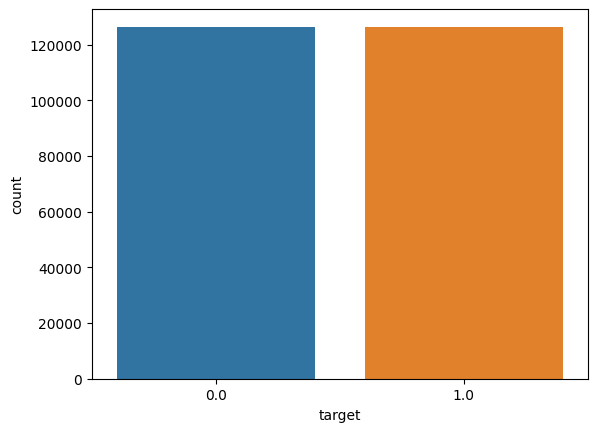

In [19]:
# handling the imbalanced
ros = RandomOverSampler(random_state=RSEED)
X_train, y_train = ros.fit_resample(X_train, y_train)

sns.countplot(x=y_train)

## Baseline model 1: Decision Tree
<span style="color:green">X_train and X_test need to have the same columns! **fixed**</span>

<span style='color:red'> In both (decision-tree & logistic regression) we have in the test data a very high accuracy in comparison to the train-data, but the ROC AUC ist lower (also the recall and precision are incredible low!)...maybe we need to check, what is our evaluation scoring?</span>

In [20]:
#baseline model 1: Decision tree
baseline_tree = DecisionTreeClassifier(random_state=RSEED, max_depth=3)
baseline_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [21]:
print(f'Decision tree has {baseline_tree.tree_.node_count} nodes with maximum depth {baseline_tree.tree_.max_depth}.')
print(f'On average there are ca. {X_train.shape[0]/baseline_tree.tree_.node_count:.1f} data points in each leaf.')

Decision tree has 15 nodes with maximum depth 3.
On average there are ca. 16851.7 data points in each leaf.


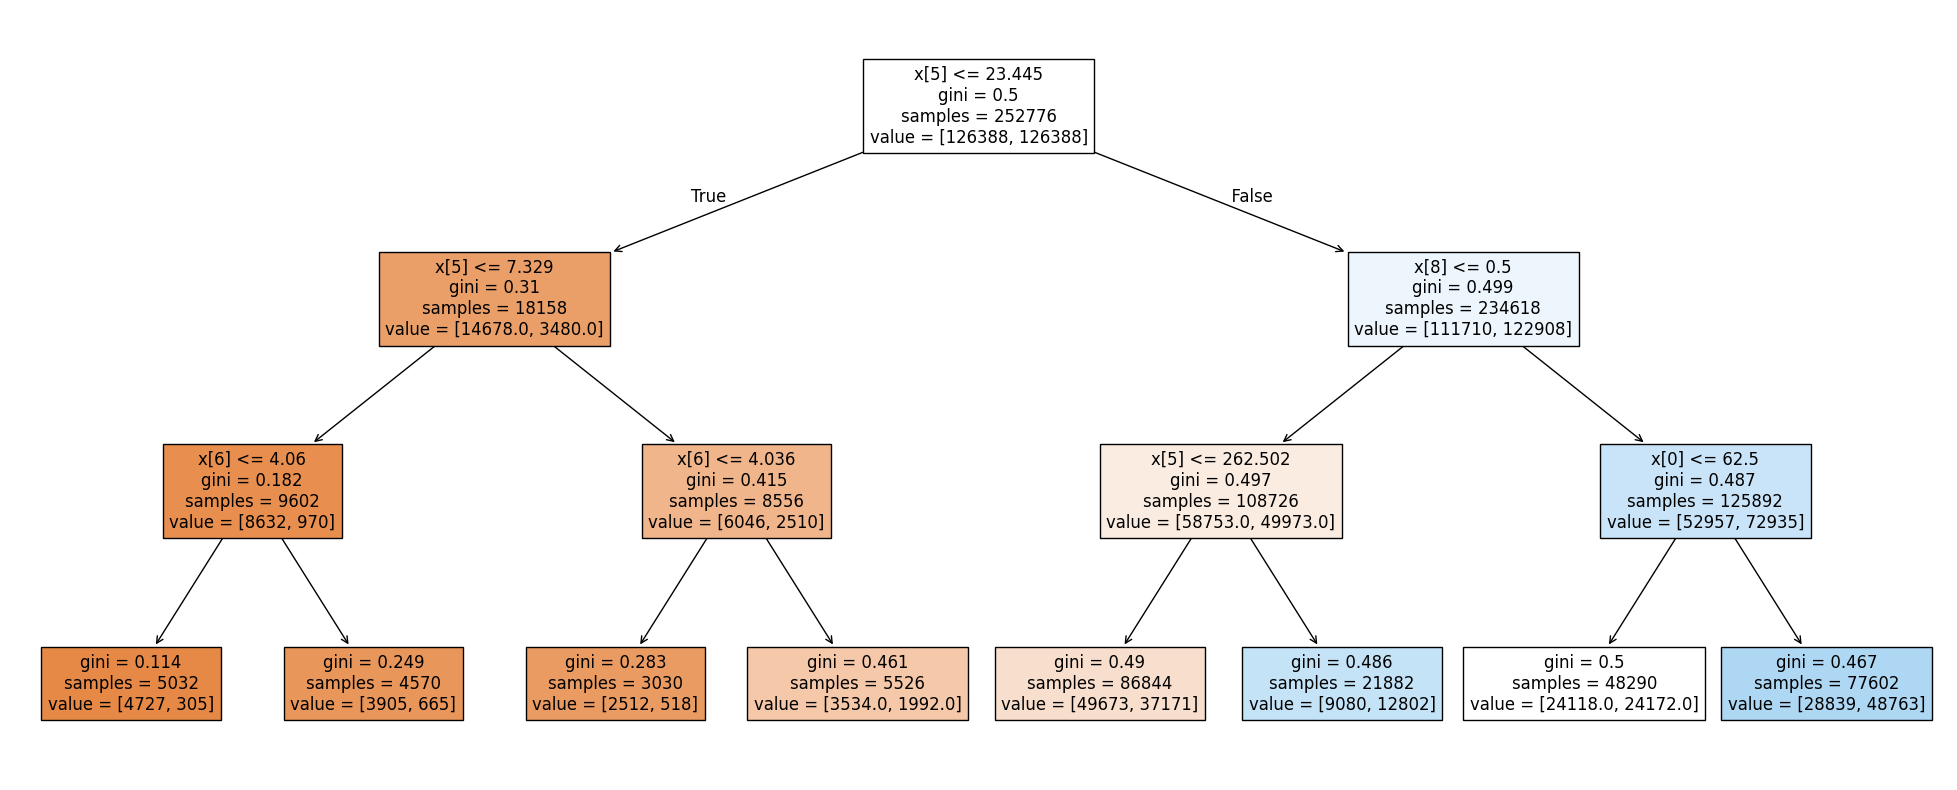

In [22]:
fig = plt.figure(figsize=(25,10))
dectree_plot = plot_tree(baseline_tree, filled=True)

In [23]:
# Make probability predictions for X_train
train_probs1 = baseline_tree.predict_proba(X_train)[:, 1]
train_predictions1 = baseline_tree.predict(X_train)

In [24]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs1)}')

Train ROC AUC Score: 0.6261704400886345


In [25]:
print(confusion_matrix(y_train, train_predictions1))
print(classification_report(y_train, train_predictions1))

[[64351 62037]
 [40651 85737]]
              precision    recall  f1-score   support

         0.0       0.61      0.51      0.56    126388
         1.0       0.58      0.68      0.63    126388

    accuracy                           0.59    252776
   macro avg       0.60      0.59      0.59    252776
weighted avg       0.60      0.59      0.59    252776



In [26]:
# Make probability predictions test data
test_probs1 = baseline_tree.predict_proba(X_test)[:, 1]
test_predictions1 = baseline_tree.predict(X_test)

In [27]:
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probs1)}')

Test ROC AUC Score: 0.5352828931482445


In [28]:
print(confusion_matrix(y_test, test_predictions1))
print(classification_report(y_test, test_predictions1))

[[777160 253349]
 [ 60257  27956]]
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83   1030509
         1.0       0.10      0.32      0.15     88213

    accuracy                           0.72   1118722
   macro avg       0.51      0.54      0.49   1118722
weighted avg       0.86      0.72      0.78   1118722



## Baseline model 2: Logistic Regression

In [40]:
# baseline 2: logistic Regression

baseline_log_reg = LogisticRegression(max_iter=900, solver='lbfgs', n_jobs=1)
baseline_log_reg.fit(X_train, y_train)

# Make probability predictions for X_train
train_probs2 = baseline_log_reg.predict_proba(X_train)[:, 1]
train_predictions2 = baseline_log_reg.predict(X_train)

In [41]:
# Results X_train prediction:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs2)}')
print(confusion_matrix(y_train, train_predictions2))
print(classification_report(y_train, train_predictions2))

Train ROC AUC Score: 0.6244971371955497
[[80352 46036]
 [58052 68336]]
              precision    recall  f1-score   support

         0.0       0.58      0.64      0.61    126388
         1.0       0.60      0.54      0.57    126388

    accuracy                           0.59    252776
   macro avg       0.59      0.59      0.59    252776
weighted avg       0.59      0.59      0.59    252776



In [42]:
# Make probability predictions for X_test
test_probs2 = baseline_log_reg.predict_proba(X_test)[:, 1]
test_predictions2 = baseline_log_reg.predict(X_test)

# Results X_test prediction:
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probs2)}')
print(confusion_matrix(y_test, test_predictions2))
print(classification_report(y_test, test_predictions2))

Test ROC AUC Score: 0.5490841746801158
[[1006962   23547]
 [  83040    5173]]
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95   1030509
         1.0       0.18      0.06      0.09     88213

    accuracy                           0.90   1118722
   macro avg       0.55      0.52      0.52   1118722
weighted avg       0.87      0.90      0.88   1118722



## HyperparameterSearch & Scoring


In [43]:
scoring = make_scorer(fbeta_score, beta=2)
cv = 5 #RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

## Model 1: Random Forest

#### with RandomizedSearch
<span style="color:red"> Caution Grid search tooks very very long!</span>


In [44]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=RSEED))]
)

In [45]:
# don't forget to add the name of the model from the pipelin in front of each hyperparameter!
param_rf = {'rf__n_estimators': np.arange(10, 201).astype(int),
    'rf__max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'rf__max_leaf_nodes': [None] + list(np.arange(10, 51).astype(int)),
    'rf__min_samples_split': [2, 5, 10],
    'rf__max_depth': [None] + list(np.arange(3, 21).astype(int)),
    'rf__bootstrap': [True, False]
    }

randomsearch_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_rf, cv=cv, scoring=scoring, n_iter=10,
                           verbose=5, n_jobs=-1) #evt. add error_score='raise'

In [46]:
randomsearch_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\email\Desktop\neuefische\0305_Challenge\my_ml_project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\email\Desktop\neuefische\0305_Challenge\my_ml_project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\email\Desktop\neuefische\0305_Challenge\my_ml_project\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('pipeline',
                                                                               Pipeline(steps=[('minmaxscaler',
                                                                                                MinMaxScaler())]),
                                                                               ['consommation_per_month',
                                                                                'months_number'])])),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__max_depth': [None, 3, 4, 5, 6, 7,
                                                          8,...
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200])},
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=5)

In [47]:
# Show best parameters
print('Best score:\n{:.2f}'.format(randomsearch_rf.best_score_))
print("Best parameters:\n{}".format(randomsearch_rf.best_params_))

Best score:
0.76
Best parameters:
{'rf__n_estimators': 117, 'rf__min_samples_split': 2, 'rf__max_leaf_nodes': 14, 'rf__max_features': 'sqrt', 'rf__max_depth': 16, 'rf__bootstrap': False}


In [48]:
# Save best model (including fitted preprocessing steps) as best_model_rf 
best_model_rf = randomsearch_rf.best_estimator_
best_model_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['consommation_per_month',
                                                   'months_number'])])),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=16,
                                        max_leaf_nodes=14, n_estimators=117,
                                        random_state=42))])

In [49]:
# Make predictions for X_train
train_probs_1 = best_model_rf.predict_proba(X_train)[:, 1]
train_predictions_1 = best_model_rf.predict(X_train)

# Results X_train prediction:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs_1)}')
print(confusion_matrix(y_train, train_predictions_1))
print(classification_report(y_train, train_predictions_1))

Train ROC AUC Score: 0.6447199561505634
[[ 47866  78522]
 [ 21224 105164]]
              precision    recall  f1-score   support

         0.0       0.69      0.38      0.49    126388
         1.0       0.57      0.83      0.68    126388

    accuracy                           0.61    252776
   macro avg       0.63      0.61      0.58    252776
weighted avg       0.63      0.61      0.58    252776



In [50]:
# make predictions for X-test
test_probs_1 = best_model_rf.predict_proba(X_test)[:, 1]
test_predictions_1 = best_model_rf.predict(X_test)

# Results X_test prediction:
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probs_1)}')
print(confusion_matrix(y_test, test_predictions_1))
print(classification_report(y_test, test_predictions_1))

Test ROC AUC Score: 0.524555330928391
[[1012728   17781]
 [  85834    2379]]
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95   1030509
         1.0       0.12      0.03      0.04     88213

    accuracy                           0.91   1118722
   macro avg       0.52      0.50      0.50   1118722
weighted avg       0.86      0.91      0.88   1118722



#### Without GridSearch

In [51]:
# Create the model with 1000 trees
model1 = RandomForestClassifier(n_estimators=1000, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.9min finished


RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42, verbose=1)

In [52]:
# Make predictions for X_train
train_probs_1 = model1.predict_proba(X_train)[:, 1]
train_predictions_1 = model1.predict(X_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   31.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   53.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   27.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   49.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.0min finished


In [53]:
# Results X_train prediction:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs_1)}')
print(confusion_matrix(y_train, train_predictions_1))
print(classification_report(y_train, train_predictions_1))

Train ROC AUC Score: 0.9999688082013758
[[126307     81]
 [    67 126321]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    126388
         1.0       1.00      1.00      1.00    126388

    accuracy                           1.00    252776
   macro avg       1.00      1.00      1.00    252776
weighted avg       1.00      1.00      1.00    252776



In [54]:
# Make predictions for X_test
test_probs_1 = model1.predict_proba(X_test)[:, 1]
test_predictions_1 = model1.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   50.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.9min finished


In [55]:
# Results X_test prediction:
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probs_1)}')
print(confusion_matrix(y_test, test_predictions_1))
print(classification_report(y_test, test_predictions_1))

Test ROC AUC Score: 0.5511797831780879
[[1013456   17053]
 [  86483    1730]]
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95   1030509
         1.0       0.09      0.02      0.03     88213

    accuracy                           0.91   1118722
   macro avg       0.51      0.50      0.49   1118722
weighted avg       0.86      0.91      0.88   1118722



## Model 2: Stacking
<span style="color:red">Integrate GridSearchCV or RandomizedGridSearchCV!</span>

In [56]:
# Stack the models Decision Tree, KNN and Random Forest
estimators = [
    ('dt', DecisionTreeClassifier(random_state = RSEED)),
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(random_state = RSEED))
]

# Fit model to training data
model2 = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())
model2.fit(X_train, y_train).score(X_test, y_test)

0.9157333099733446

In [57]:
# Make predictions for X_train
train_probs_2 = model2.predict_proba(X_train)[:, 1]
train_predictions_2 = model2.predict(X_train)

In [58]:
# Results X_train prediction:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs_2)}')
print(confusion_matrix(y_train, train_predictions_2))
print(classification_report(y_train, train_predictions_2))

Train ROC AUC Score: 0.9999569910692836
[[126379      9]
 [   230 126158]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    126388
         1.0       1.00      1.00      1.00    126388

    accuracy                           1.00    252776
   macro avg       1.00      1.00      1.00    252776
weighted avg       1.00      1.00      1.00    252776



In [59]:
# Make predictions for X_test
test_probs_2 = model1.predict_proba(X_test)[:, 1]
test_predictions_2 = model1.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   48.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   50.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.9min finished


In [60]:
# Results X_test prediction:
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probs_2)}')
print(confusion_matrix(y_test, test_predictions_2))
print(classification_report(y_test, test_predictions_2))

Test ROC AUC Score: 0.5511797831780879
[[1013456   17053]
 [  86483    1730]]
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95   1030509
         1.0       0.09      0.02      0.03     88213

    accuracy                           0.91   1118722
   macro avg       0.51      0.50      0.49   1118722
weighted avg       0.86      0.91      0.88   1118722



### Model 3: Boosting (XGBoost)

# Fit model to training data
model3 = XGBClassifier(random_state=RSEED,
                    n_jobs=-1,
                    n_estimators=1000,
                    learning_rate=0.3,
                    subsample=0.5,
                    )
                    
model3.fit(X_train, y_train)

## Evaluate the models

In [62]:
#NOCH ANZUPASSEN!


def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
   baseline_tree = {}
    
   baseline_tree['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
   baseline_tree['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
   baseline_tree['roc'] = roc_auc_score(y_test, y_probs)

   baseline_log_reg = {}
    
   baseline_log_reg['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
   baseline_log_reg['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
   baseline_log_reg['roc'] = roc_auc_score(y_test, y_probs)
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 8)